In [2]:
import numpy as np
import pandas as pd
import os
import cv2

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

In [4]:
batch_size = 40
img_height = 256
img_width = 256

In [5]:
## loading training data
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/ceng-407-408-2022-2023-Drowsy-Driver-Detection-System/Dataset/dataset/train',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

## loading testing data
testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
'/content/ceng-407-408-2022-2023-Drowsy-Driver-Detection-System/Dataset/dataset/test',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

Found 2467 files belonging to 4 classes.
Found 391 files belonging to 4 classes.


In [6]:
class_names = training_ds.class_names
print(class_names)

['Closed', 'Open', 'no_yawn', 'yawn']


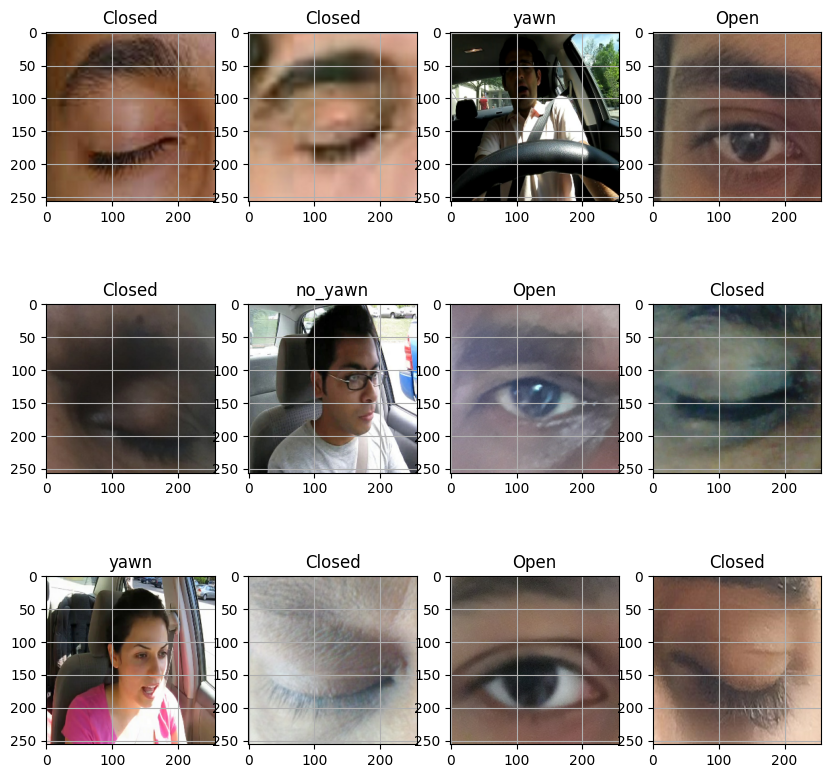

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3,4 , i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.grid(True)

In [14]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential(
  [
    layers.RandomRotation(0.1, input_shape=(img_height,img_width,3)), # Added input_shape here
    layers.RandomZoom(0.1),
    layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0),
    layers.RandomFlip("horizontal")
  ]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-rlt_gane
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models /tmp/pip-req-build-rlt_gane
  Resolved https://github.com/qubvel/segmentation_models to commit 5d24bbfb28af6134e25e2c0b79e7727f6c0491d0
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.1 MB/s eta 0:00:00
  Created wheel for segmentation_models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33790 sha256=4140882a1e9e0fb02257aea5152cb3fd62a1203f77342eba35787d1ea8ac50b5
  Stored in directory: /tmp/pip-ephem-wheel-cache-r19nnztq/wheels/ce/d6/f1/5d00e82b3893c5f1ffee43bf7b8877148af09c7c9c6c4882c9
Successfully built segmentation_models


In [10]:
from keras import applications

In [11]:
from tensorflow.keras.optimizers import Adam

In [12]:
from tensorflow.keras.applications import ResNet152V2

In [16]:
import efficientnet.tfkeras as efn
model = tf.keras.Sequential([data_augmentation,
      layers.Rescaling(1./255),
                            ResNet152V2(include_top=False, weights='imagenet', input_shape=(256,256,3)),
                                 layers.GlobalAveragePooling2D(),
                                 layers.Dropout(0.4),
                                 layers.BatchNormalization(),
                                 layers.Dense(64, activation='relu'),
                                 layers.BatchNormalization(),
                                 layers.Dropout(0.4),

                                 layers.Dense(4,
                                         activation='softmax')])



early_stopping = tf.keras.callbacks.EarlyStopping(patience=16,
                                                  monitor="val_loss",
                                                  verbose=2,
                                                  mode="auto")
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.keras",
                                                monitor="val_loss",
                                                mode="auto",
                                                verbose=2,
                                                save_best_only=True)
model.compile(optimizer='adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [17]:

history = model.fit(
    training_ds,
    validation_data=testing_ds,
    epochs=64,
    callbacks=[early_stopping,checkpoint]
)

Epoch 1/64
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6775 - loss: 0.8670
Epoch 1: val_loss improved from inf to 861.45844, saving model to best.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.6786 - loss: 0.8638 - val_accuracy: 0.2532 - val_loss: 861.4584
Epoch 2/64
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8994 - loss: 0.2670
Epoch 2: val_loss improved from 861.45844 to 19.92719, saving model to best.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.8998 - loss: 0.2663 - val_accuracy: 0.4859 - val_loss: 19.9272
Epoch 3/64
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9581 - loss: 0.1324
Epoch 3: val_loss improved from 19.92719 to 0.27636, saving model to best.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.9583 - loss: 0.1320 - val_accuracy: 0.9233 - val_loss: 0.2764
Epoch 4/64
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9800 - loss: 0.0696
Epoch 4: val_loss improved from 0.27636 to 0.09338, saving model to best.keras

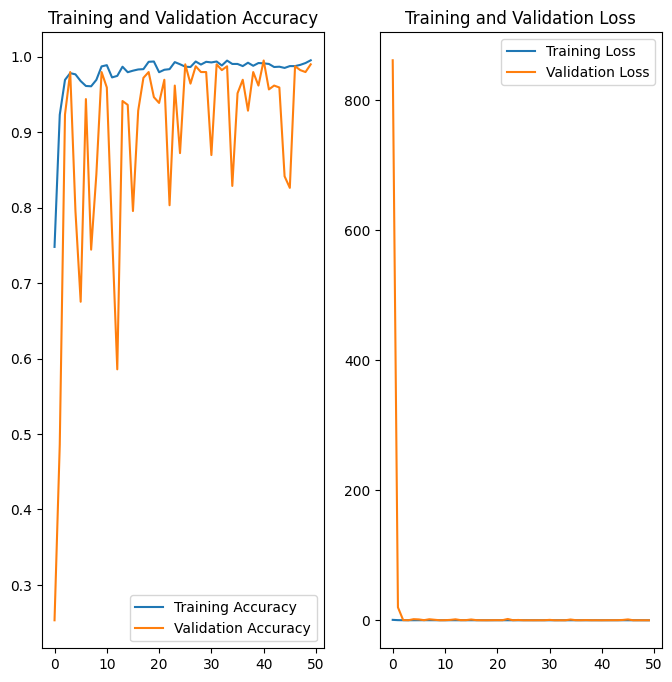

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = len(acc)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 5s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


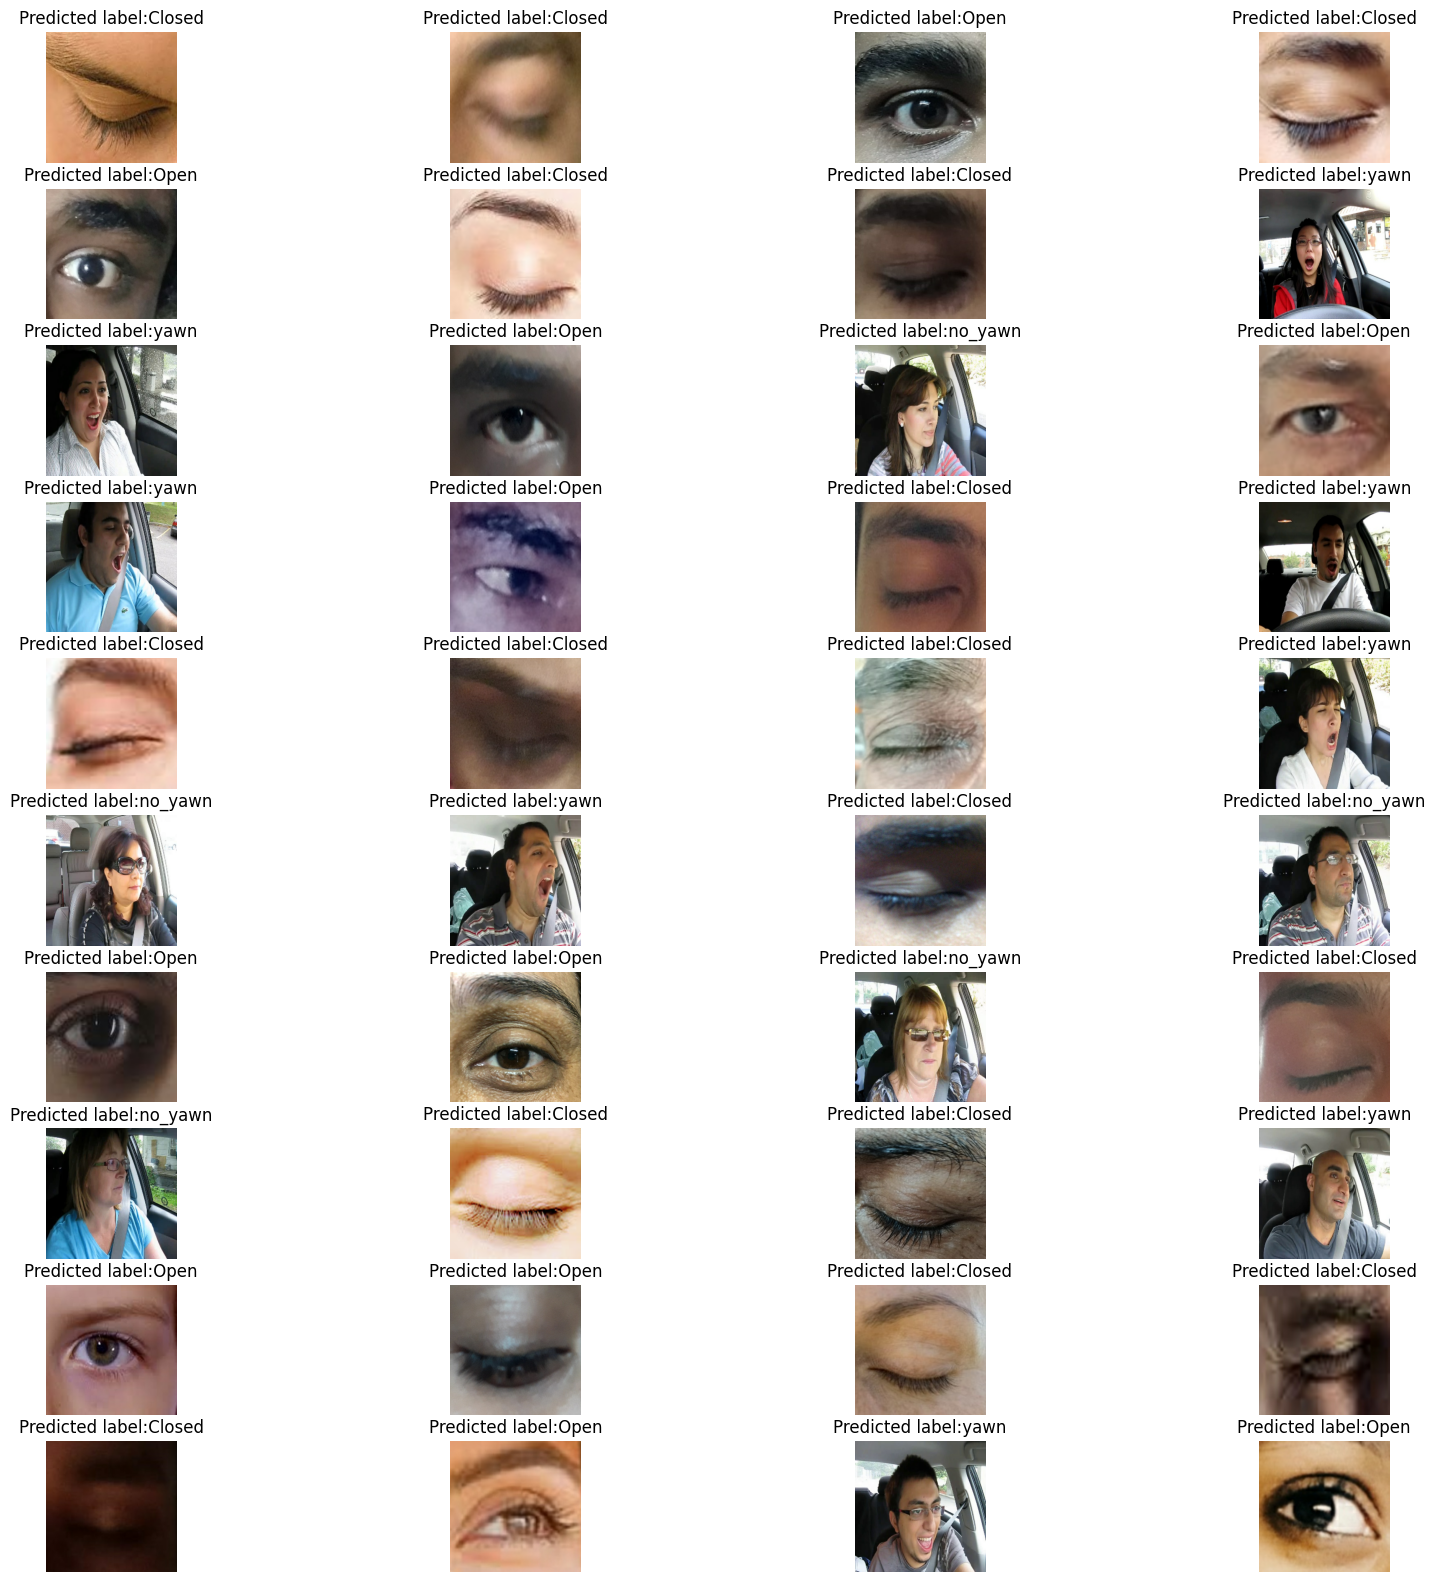

In [19]:
plt.figure(figsize=(20, 20))
for images, labels in testing_ds.take(2):
    predictions = model.predict(images)
    predlabel = []

    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])

    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Predicted label:'+ predlabel[i])
        plt.axis('off')
        plt.grid(True)